In [1]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pywt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential
from keras.models import Model
from keras.utils import plot_model

In [2]:
base_dir = r".\DATASET_10000x9"
csv_path = os.path.join(base_dir, "labels.csv")
IMG_H, IMG_W, BATCH = 224, 224, 16
SEED = 42

In [3]:
dataset_name   = os.path.basename(base_dir)
df = pd.read_csv(csv_path)

df['filepath'] = df['filepath'].str.replace('\\', '/', regex=False)
pattern = rf'^(?:\./)?{re.escape(dataset_name)}/'
df['filepath'] = df['filepath'].str.replace(pattern, '', regex=True)

In [4]:
df

,filepath,label
0,original/000000000025.jpg,Original
1,salt_pepper/000000000025.jpg,Salt & Pepper
2,gaussian/000000000025.jpg,Gaussian
3,uniform/000000000025.jpg,Uniform
4,erlang_rayleigh/000000000025.jpg,Erlang/Rayleigh
...,...,...
89995,erlang_rayleigh/000000581929.jpg,Erlang/Rayleigh
89996,periodic/000000581929.jpg,Periodic
89997,speckle/000000581929.jpg,Speckle
89998,striping_vertical/000000581929.jpg,Striping Vertical


In [5]:
# Split stratificati (stessi esempi per classe)

# 80-10-10 training-validation-test split

# Splitto tutto in training e "temp"
train_df, temp_df = train_test_split(df, test_size=0.20, stratify=df['label'], random_state=SEED)

# Splitto temp in validation e test
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)

print(f"Train: {len(train_df)/len(df)*100:.1f}%  |  Val: {len(val_df)/len(df)*100:.1f}%  |  Test: {len(test_df)/len(df)*100:.1f}%")

Train: 80.0%  |  Val: 10.0%  |  Test: 10.0%


In [6]:
# Preprocessing: rescaling, resizing, shuffling, one hot encoding

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df, directory=base_dir,
    x_col="filepath", y_col="label", # colonne di df_train
    target_size=(IMG_H, IMG_W), # da settare bene
    batch_size=BATCH,
    class_mode="categorical", # voglio fare ohe
    shuffle=True,
    seed=SEED
)
val_gen = datagen.flow_from_dataframe(
    val_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)
test_gen = datagen.flow_from_dataframe(
    test_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)

train_gen.class_indices

Found 72000 validated image filenames belonging to 9 classes.
Found 9000 validated image filenames belonging to 9 classes.
Found 9000 validated image filenames belonging to 9 classes.


{'Erlang/Rayleigh': 0,
 'Gaussian': 1,
 'Original': 2,
 'Periodic': 3,
 'Salt & Pepper': 4,
 'Speckle': 5,
 'Striping Horizontal': 6,
 'Striping Vertical': 7,
 'Uniform': 8}

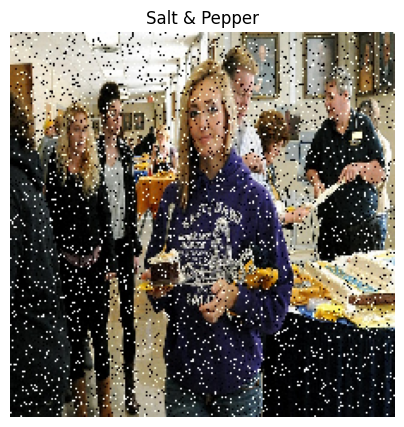

In [7]:
def plot_image(generator):
    """
    Estrae un'immagine random dal DirectoryIterator `generator`
    e la plotta con la sua label.
    """
    # 1) Scelgo un indice casuale tra 0 e generator.samples-1
    idx = random.randint(0, generator.samples - 1)
    
    # 2) Recupero il path assoluto dell'immagine
    img_path = generator.filepaths[idx]
    
    # 3) Carico e ridimensiono l'immagine secondo target_size del generatore
    img = load_img(img_path, target_size=generator.target_size)
    img_arr = img_to_array(img) / 255.0   # normalizzo [0,1]
    
    # 4) Trovo la label corrispondente
    class_idx = generator.classes[idx]
    inv_map = {v: k for k, v in generator.class_indices.items()}
    label = inv_map[class_idx]
    
    # 5) Plotto
    plt.figure(figsize=(5,5))
    plt.imshow(img_arr)
    plt.title(label)
    plt.axis('off')
    plt.show()

plot_image(train_gen)

In [8]:
model = models.Sequential()
model.add(layers.Input(shape=(IMG_H, IMG_W, 3)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(train_gen.class_indices), activation='softmax'))

In [136]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_H, IMG_W, 3)
)

# Transfer Learning: all original layers are frozen
for layer in base_model.layers:
    layer.trainable = True


model = Sequential([
    base_model, # tutto il backbone freezato InceptionV3
    layers.GlobalAveragePooling2D(name='avg_pool'), # riduzione parametri
    layers.Dense(128, activation='relu', name='fc1'),
    layers.Dropout(0.5, name='dropout'), # cerco di evitare overfitting
    layers.Dense(len(train_gen.class_indices), activation='softmax', name='predictions')
])

In [9]:
# Imposto batch_size per ridurre overhead cpu-gpu (cpu è il bottleneck)
BATCH = 16
train_gen.batch_size = BATCH
val_gen.batch_size   = BATCH
test_gen.batch_size  = BATCH

steps_per_epoch    = train_gen.samples // BATCH
validation_steps  = val_gen.samples // BATCH

In [10]:
# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

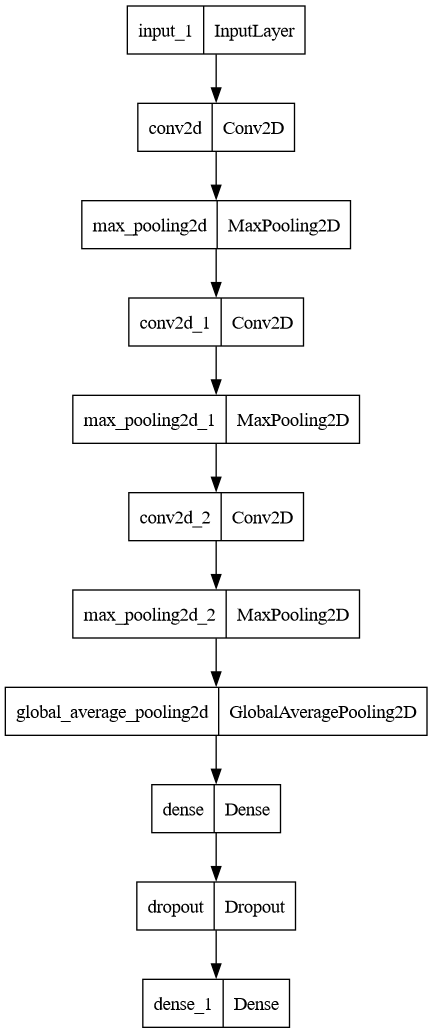

In [33]:
plot_model(model)

In [11]:
es = EarlyStopping(
    monitor='val_loss',
    patience=5, # mi fermo se per 5 epochs non miglioro
    restore_best_weights=True # ripristino pesi migliori (prima di overfittare)
)

mc = ModelCheckpoint(
    'best_model_GAP.h5', 
    monitor='val_loss',
    save_best_only=True # salvo solo il modello con val_loss migliore
)

In [12]:
import tensorflow as tf

print("✅ TensorFlow version:", tf.__version__)
print("🖥️ GPU rilevate:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ La GPU è attiva e disponibile! 🚀")
else:
    print("❌ Nessuna GPU disponibile.")


✅ TensorFlow version: 2.10.1
🖥️ GPU rilevate: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ La GPU è attiva e disponibile! 🚀


In [36]:
# Training
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch, # numero batch in una epoch di training
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=[es, mc], # Early Stopping + best model checkpoint
    workers=4, # numero thread in parallelo
    use_multiprocessing=False, # non si può
    max_queue_size=10
)

Epoch 1/100
4500/4500 [==============================] - 299s 65ms/step - loss: 0.9858 - accuracy: 0.5775 - val_loss: 0.5476 - val_accuracy: 0.7452
Epoch 2/100
4500/4500 [==============================] - 224s 50ms/step - loss: 0.5783 - accuracy: 0.7449 - val_loss: 0.4893 - val_accuracy: 0.7955
Epoch 3/100
4500/4500 [==============================] - 221s 49ms/step - loss: 0.4786 - accuracy: 0.7962 - val_loss: 0.4177 - val_accuracy: 0.8319
Epoch 4/100
4500/4500 [==============================] - 223s 50ms/step - loss: 0.3831 - accuracy: 0.8493 - val_loss: 0.2871 - val_accuracy: 0.9027
Epoch 5/100
4500/4500 [==============================] - 223s 50ms/step - loss: 0.2712 - accuracy: 0.9040 - val_loss: 0.1769 - val_accuracy: 0.9359
Epoch 6/100
4500/4500 [==============================] - 221s 49ms/step - loss: 0.2210 - accuracy: 0.9227 - val_loss: 0.1744 - val_accuracy: 0.9359
Epoch 7/100
4500/4500 [==============================] - 223s 50ms/step - loss: 0.1873 - accuracy: 0.9365 - val_

In [22]:
model.save('final_model.h5')

In [13]:
model = load_model('GOAT.h5')

45% accuracy con 100 immagini per classe

40% accuracy con InceptionV3 transfer learning

57% accuracy con InceptionV3 fine tuning su 100 layers

64.6% accuracy con 2000 immagini per classe

65.8% accuracy con GAP

88-93% con GAP e alpha = 0.0001 (114 epochs)

96% con GAP, alpha=0.001 (28 epochs), 20s per epoch, batch = 16

98% FINALE (GAP, alpha=0.001, 23 epochs, 222s per epoch, 1.5h tot, batch=16, 90k immagini)

In [37]:
test_loss, test_acc = model.evaluate(test_gen)

563/563 [==============================] - 97s 171ms/step - loss: 0.0620 - accuracy: 0.9828


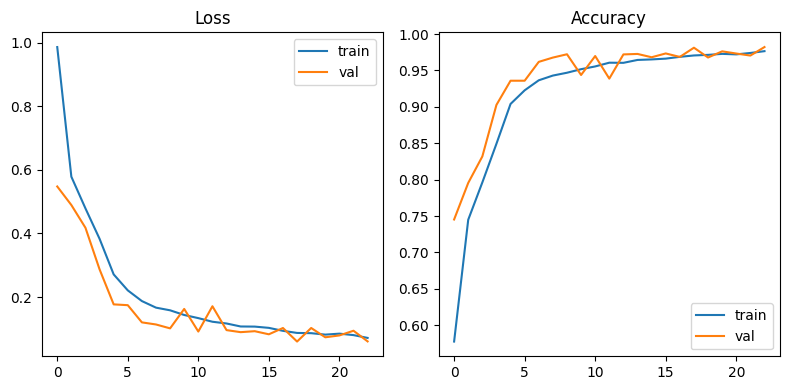

In [38]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 17ms/step


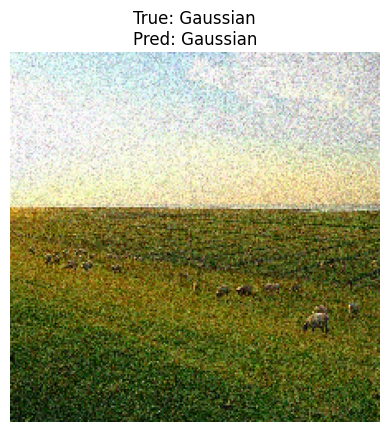

In [35]:
def show_random_prediction_tf(model, test_gen):
    """
    Seleziona un'immagine a caso dal test_gen di Keras, mostra l'immagine,
    la label effettiva e quella predetta dal modello.
    """
    # Costruisci lista di class names ordinata per indice
    class_indices = test_gen.class_indices
    class_names = [None] * len(class_indices)
    for cls, idx in class_indices.items():
        class_names[idx] = cls

    # Pesca un batch casuale
    total_batches = len(test_gen)
    batch_idx = random.randrange(total_batches)
    x_batch, y_batch = test_gen[batch_idx]

    # Pesca un campione casuale all'interno del batch
    sample_idx = random.randrange(x_batch.shape[0])
    img = x_batch[sample_idx]
    true_idx = np.argmax(y_batch[sample_idx])

    # Predizione
    preds = model.predict(img[np.newaxis, ...])
    pred_idx = np.argmax(preds[0])

    # Visualizza
    plt.imshow(img)
    plt.title(f"True: {class_names[true_idx]}\nPred: {class_names[pred_idx]}")
    plt.axis('off')
    plt.show()

# Esempio di utilizzo:
show_random_prediction_tf(model, test_gen)

In [50]:
pred_probs = model.predict(test_gen, verbose=1)

563/563 [==============================] - 27s 49ms/step


In [51]:
y_pred = np.argmax(pred_probs, axis=1) # y predicted
y_true = test_gen.classes # y actual

In [52]:
class_indices = test_gen.class_indices
class_names = [None] * len(class_indices)
for cls, idx in class_indices.items():
    class_names[idx] = cls

print(class_names)

['Erlang/Rayleigh', 'Gaussian', 'Original', 'Periodic', 'Salt & Pepper', 'Speckle', 'Striping Horizontal', 'Striping Vertical', 'Uniform']


In [53]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

                     precision    recall  f1-score   support

    Erlang/Rayleigh       0.99      0.97      0.98      1000
           Gaussian       0.94      0.99      0.96      1000
           Original       0.98      0.97      0.97      1000
           Periodic       0.98      0.98      0.98      1000
      Salt & Pepper       1.00      1.00      1.00      1000
            Speckle       0.97      0.98      0.98      1000
Striping Horizontal       1.00      1.00      1.00      1000
  Striping Vertical       1.00      0.99      0.99      1000
            Uniform       0.98      0.97      0.97      1000

           accuracy                           0.98      9000
          macro avg       0.98      0.98      0.98      9000
       weighted avg       0.98      0.98      0.98      9000



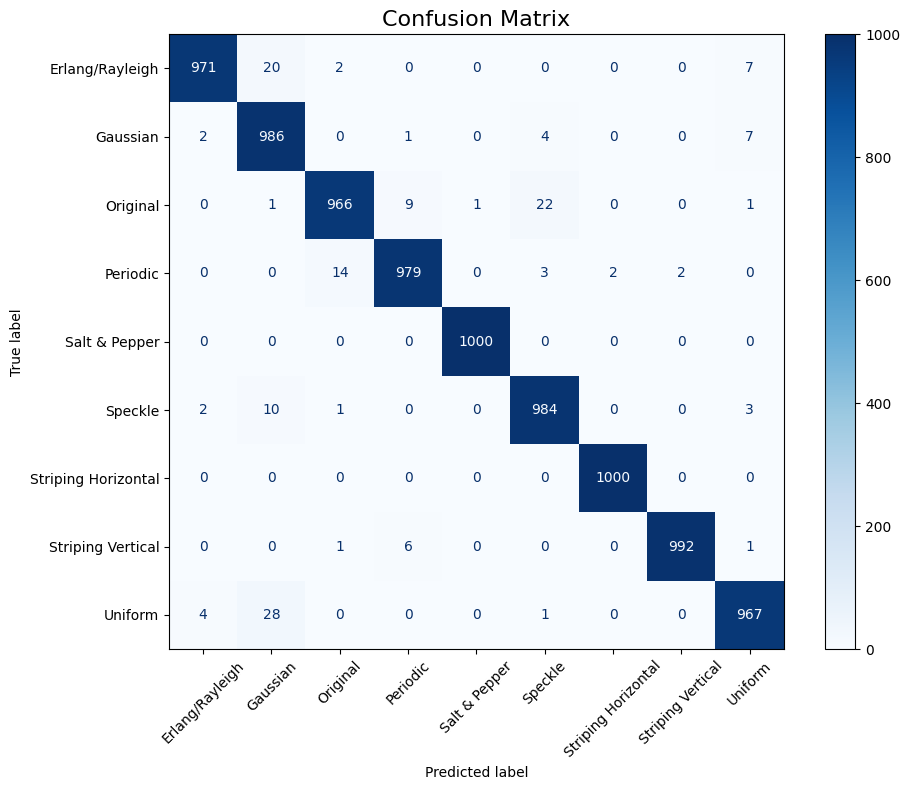

In [ ]:
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45, values_format='d') # metto labels diagonali cosi non si sovrappongono

ax.set_title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()